# Setup

In [1]:
# Packages -----------------------------------------------#

# Data Analysis
import xarray as xr
import numpy as np
import pandas as pd
import metpy.calc as mpcalc
import matplotlib.dates as dates
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# Timing Processes and Progress
import time
from tqdm import tqdm

# make sure the figures plot inline rather than at the end
%matplotlib inline

# get data from tigress
path = '/home/jennap/projects/LRGROUP/shared_data/ssh_AVISO/'
# slainfn = 'all_adt_sla_global_twosat_phy_l4_vDT2018_daily_1994_2018.nc'
slainfn = 'all_adt_sla_global_twosat_phy_l4_vDT2018_daily_1994_2020_03_01.nc'

ds = xr.open_dataset(path + slainfn)
#print(ds.keys())

# Subset ------------------------------------------------#
# Create slice variables to subset domain before finding means
lat_slice = slice(-20, 30) # bounds inclusive
lon_slice = slice(35, 120) # bounds inclusive

# Get data, selecting lat/lon slice
daily_sla = ds['sla'].sel(latitude=lat_slice,longitude=lon_slice)
lat = daily_sla.latitude.values
lon = daily_sla.longitude.values

del lat_slice, lon_slice

# Detrend SLA

Resources: [link](https://ecco-v4-python-tutorial.readthedocs.io/ECCO_v4_Example_calculations_with_scalar_quantities.html), [link](https://groups.google.com/g/xarray/c/fz7HHgpgwk0), [link](https://stackoverflow.com/questions/28647172/numpy-polyfit-doesnt-handle-nan-values), [link](https://stackoverflow.com/questions/28647172/numpy-polyfit-doesnt-handle-nan-values), [link](https://stackoverflow.com/questions/17638137/curve-fitting-to-a-time-series-in-the-format-datetime)



In [2]:
%%time

# stack lat and lon into a single dimension called allpoints
stacked = daily_sla.stack(allpoints=['latitude','longitude'])

# set places where there are nans to zero since polyfit can't deal with them
stacked_nonan = stacked.fillna(0)

# convert date to a number to polyfit can handle it
datenum = dates.date2num(stacked_nonan.time)
daily_sla_slope, daily_sla_intercept = np.polyfit(datenum, stacked_nonan, 1)

#reshape the data
daily_sla_slope = np.reshape(daily_sla_slope, daily_sla.shape[1:3])
daily_sla_intercept = np.reshape(daily_sla_intercept, daily_sla.shape[1:3])

# define a function to compute a linear trend of a timeseries
def linear_detrend(y):
    x = dates.date2num(y.time)
    m, b = np.polyfit(x, y, 1)
    # we need to return a dataarray or else xarray's groupby won't be happy
    return xr.DataArray(y - (m*x + b))

# apply the function over allpoints to calculate the trend at each point
daily_sla_dtrnd = stacked_nonan.groupby('allpoints').apply(linear_detrend)
# unstack back to lat lon coordinates
daily_sla_dtrnd = daily_sla_dtrnd.unstack('allpoints')

# fill all points we set originally to zero back to nan
daily_sla_dtrnd = daily_sla_dtrnd.where(~np.isnan(daily_sla))

# delete trended data to save on memory
del daily_sla,ds, stacked, stacked_nonan

# make plot for this to show difference..

CPU times: user 2h 6min 9s, sys: 5min 23s, total: 2h 11min 32s
Wall time: 7min 2s


# Downsample to Monthly and Seasonal Temporal Resolution

In [3]:
%%time
# monthly
mon_sla_dtrnd = daily_sla_dtrnd.resample(time='1MS').mean(dim="time")
# seasonal
seas_sla_dtrnd = daily_sla_dtrnd.resample(time='QS-DEC').mean(dim="time")

/home/jennap/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


CPU times: user 5min 53s, sys: 14.6 s, total: 6min 8s
Wall time: 12.3 s


# Find Climatologies 
Resources: [link](http://xarray.pydata.org/en/stable/examples/monthly-means.html)

In [4]:
%%time
# -------------------------------------------
# weighted seasonal
# -------------------------------------------

# get months
month_length = daily_sla_dtrnd.time.dt.days_in_month

# calculate the weights by grouping by 'time.season'.
weights = month_length.groupby('time.season') / month_length.groupby('time.season').sum()

# calculate the weighted average
sla_seas_clim_dtrnd = (daily_sla_dtrnd * weights).groupby('time.season').sum(dim='time')   

# set the places that are now zero from the weights to nans
sla_seas_clim_dtrnd = sla_seas_clim_dtrnd.where(sla_seas_clim_dtrnd != 0,np.nan) # for some reason .where sets the locations not in the condition to nan by default

# -------------------------------------------
# monthly
# -------------------------------------------

sla_mon_clim_dtrnd = daily_sla_dtrnd.groupby('time.month').mean('time') 

/home/jennap/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


CPU times: user 1min 32s, sys: 7.27 s, total: 1min 40s
Wall time: 13.4 s


# Find Anomalies

In [5]:
%%time

# # daily data - monthly climatology
# daily_sla_mon_anom_dtrnd = daily_sla_dtrnd.groupby('time.month') - sla_mon_clim_dtrnd

# monthly avg data - monthly climatology
mon_sla_mon_anom_dtrnd = mon_sla_dtrnd.groupby('time.month') - sla_mon_clim_dtrnd

# # monthly avg data - seasonal climatology
# seas_sla_mon_anom_dtrnd = mon_sla_dtrnd.groupby('time.season') - sla_seas_clim_dtrnd

# seasonal avg data - seasonal climatology
seas_sla_seas_anom_dtrnd = mon_sla_dtrnd.groupby('time.season') - sla_seas_clim_dtrnd

CPU times: user 9.07 s, sys: 518 ms, total: 9.58 s
Wall time: 557 ms


# Put into bins

In [6]:
#%%time

def latlon_coarsen(invar,lat,lon,bounds,binwidth = 1):
    import numpy as np
 
    # create a pandas dataframe
    df = pd.DataFrame(dict(
            invar = np.array(invar),
            lat= np.array(lat),
            lon= np.array(lon)
        ))
    
    # create 1 degree bins
    latedges = np.arange(bounds[2]-(binwidth/2),bounds[3]+(binwidth/2),binwidth)
    lat_inds = list(range(len(latedges)-1))

    lonedges = np.arange(bounds[0]-(binwidth/2),bounds[1]+(binwidth/2),binwidth)
    lon_inds = list(range(len(lonedges)-1))

    latbins = latedges[1:]-(binwidth/2)
    lonbins = lonedges[1:]-(binwidth/2)

    df['latedges'] = pd.cut(lat, latedges)
    df['lonedges'] = pd.cut(lon, lonedges)
    df['latbins_ind'] = pd.cut(lat, latedges,labels = lat_inds)
    df['lonbins_ind'] = pd.cut(lon, lonedges,labels = lon_inds)
    df['lat_lon_indx']=df.groupby(['latbins_ind', 'lonbins_ind']).ngroup()
    grouped = df.groupby(['latbins_ind', 'lonbins_ind'])

    invar_BINNED = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray)
    invar_BINNED[:] = np.nan

    invar_binned_ave = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray)
    invar_binned_ave[:] = np.nan


    #extract the data for each group
    for name, group in grouped:
        i = np.array(group.latbins_ind)
        j = np.array(group.lonbins_ind)

        invar_BINNED[i[0],j[0]] = group.invar

        invar_binned_ave[i[0],j[0]] = np.nanmean(group.invar)

    return np.array(invar_binned_ave,dtype = float),lonbins,latbins

# grid lat lon data
xx,yy = np.meshgrid(lon,lat)

# define extent of grid
bounds = [35,120,-20,30]

_,lonbins_1deg,latbins_1deg =latlon_coarsen(np.array(mon_sla_mon_anom_dtrnd[0,:,:]).ravel(),yy.ravel(),xx.ravel(),bounds,1)
_,lonbins_2deg,latbins_2deg =latlon_coarsen(np.array(mon_sla_mon_anom_dtrnd[0,:,:]).ravel(),yy.ravel(),xx.ravel(),bounds,2)

# monthly climatology
sla_mon_clim_dtrnd_1deg=np.zeros([sla_mon_clim_dtrnd.shape[0],len(latbins_1deg),len(lonbins_1deg)])
for tt in range(sla_mon_clim_dtrnd.shape[0]):
    sla_mon_clim_dtrnd_1deg[tt,:,:],_,_ = latlon_coarsen(np.array(sla_mon_clim_dtrnd[tt,:,:]).ravel(),yy.ravel(),xx.ravel(),bounds,1)

sla_mon_clim_dtrnd_2deg=np.zeros([sla_mon_clim_dtrnd.shape[0],len(latbins_2deg),len(lonbins_2deg)])
for tt in range(sla_mon_clim_dtrnd.shape[0]):
    sla_mon_clim_dtrnd_2deg[tt,:,:],_,_ = latlon_coarsen(np.array(sla_mon_clim_dtrnd[tt,:,:]).ravel(),yy.ravel(),xx.ravel(),bounds,2)


# monthly anomaly
mon_sla_mon_anom_dtrnd_1deg=np.zeros([mon_sla_mon_anom_dtrnd.shape[0],len(latbins_1deg),len(lonbins_1deg)])
for tt in range(mon_sla_mon_anom_dtrnd.shape[0]):
    mon_sla_mon_anom_dtrnd_1deg[tt,:,:],_,_= latlon_coarsen(np.array(mon_sla_mon_anom_dtrnd[tt,:,:]).ravel(),yy.ravel(),xx.ravel(),bounds,1)

mon_sla_mon_anom_dtrnd_2deg=np.zeros([mon_sla_mon_anom_dtrnd.shape[0],len(latbins_2deg),len(lonbins_2deg)])
for tt in range(mon_sla_mon_anom_dtrnd.shape[0]):
    mon_sla_mon_anom_dtrnd_2deg[tt,:,:],_,_ = latlon_coarsen(np.array(mon_sla_mon_anom_dtrnd[tt,:,:]).ravel(),yy.ravel(),xx.ravel(),bounds,2)
    
# seasonal climatology
sla_seas_clim_dtrnd_1deg=np.zeros([sla_seas_clim_dtrnd.shape[0],len(latbins_1deg),len(lonbins_1deg)])
for tt in range(sla_seas_clim_dtrnd.shape[0]):
    sla_seas_clim_dtrnd_1deg[tt,:,:],_,_ = latlon_coarsen(np.array(sla_seas_clim_dtrnd[tt,:,:]).ravel(),yy.ravel(),xx.ravel(),bounds,1)

sla_seas_clim_dtrnd_2deg=np.zeros([sla_seas_clim_dtrnd.shape[0],len(latbins_2deg),len(lonbins_2deg)])
for tt in range(sla_seas_clim_dtrnd.shape[0]):
    sla_seas_clim_dtrnd_2deg[tt,:,:],_,_ = latlon_coarsen(np.array(sla_seas_clim_dtrnd[tt,:,:]).ravel(),yy.ravel(),xx.ravel(),bounds,2)

# seasonal anomaly
seas_sla_seas_anom_dtrnd_1deg=np.zeros([seas_sla_seas_anom_dtrnd.shape[0],len(latbins_1deg),len(lonbins_1deg)])
for tt in range(seas_sla_seas_anom_dtrnd.shape[0]):
    seas_sla_seas_anom_dtrnd_1deg[tt,:,:],_,_ = latlon_coarsen(np.array(seas_sla_seas_anom_dtrnd[tt,:,:]).ravel(),yy.ravel(),xx.ravel(),bounds,1)

seas_sla_seas_anom_dtrnd_2deg=np.zeros([seas_sla_seas_anom_dtrnd.shape[0],len(latbins_2deg),len(lonbins_2deg)])
for tt in range(seas_sla_seas_anom_dtrnd.shape[0]):
    seas_sla_seas_anom_dtrnd_2deg[tt,:,:],_,_ = latlon_coarsen(np.array(seas_sla_seas_anom_dtrnd[tt,:,:]).ravel(),yy.ravel(),xx.ravel(),bounds,2)



/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mea

/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mea

/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mea

/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mea

/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mea

/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mea

/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mea

/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mea

/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mea

/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mea

/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mea

/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mea

/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mea

/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mea

/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mea

/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mea

/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mea

/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mea

In [7]:
latbins_2deg.shape

(25,)

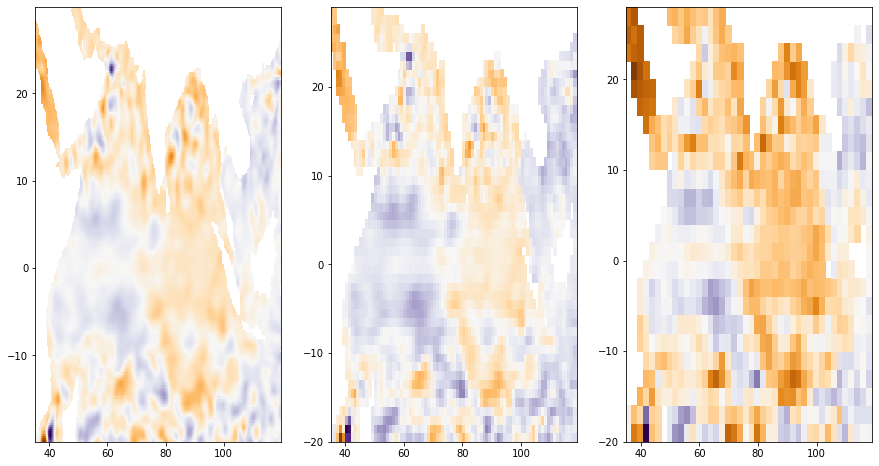

In [8]:
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(1,3,1)
plt.pcolormesh(xx,yy,mon_sla_mon_anom_dtrnd[0,:,:],cmap=plt.cm.PuOr_r)

ax = fig.add_subplot(1,3,2)
plt.pcolormesh(lonbins_1deg,latbins_1deg,mon_sla_mon_anom_dtrnd_1deg[0,:,:],cmap=plt.cm.PuOr_r)

ax = fig.add_subplot(1,3,3)
plt.pcolormesh(lonbins_2deg,latbins_2deg,mon_sla_mon_anom_dtrnd_2deg[0,:,:],cmap=plt.cm.PuOr_r)

## AWG regridding

In [9]:
# get merged data from tigress
path = '/home/jennap/projects/LRGROUP/shared_data/Merged_ARGO_WOD_GOSHIP/'
infn = 'Profiles_temp_psal_doxy.nc'

ds_AWG = xr.open_dataset(path + infn)
# print(ds.keys())

# change time variable ----------------------------------#
# set the units to be something xarray can decode
ds_AWG.time.attrs['units'] = 'days since 01-01-1800'
#re-decode the dataset
ds_AWG = xr.decode_cf(ds_AWG)

# # add time as a coordinate
ds_AWG= ds_AWG.assign_coords(unsorted_time=ds_AWG.time)

# reset profile variables to be with respect to time
ds_AWG['temp'] = xr.DataArray(ds_AWG.temp,dims = ['unsorted_time','pres'],coords =[ds_AWG.time,ds_AWG.pres])
ds_AWG['psal'] = xr.DataArray(ds_AWG.psal,dims = ['unsorted_time','pres'],coords =[ds_AWG.time,ds_AWG.pres])
ds_AWG['doxy'] = xr.DataArray(ds_AWG.doxy,dims = ['unsorted_time','pres'],coords =[ds_AWG.time,ds_AWG.pres])
ds_AWG['lat'] = xr.DataArray(ds_AWG.lat,dims = ['unsorted_time'],coords =[ds_AWG.time])
ds_AWG['lon'] = xr.DataArray(ds_AWG.lon,dims = ['unsorted_time'],coords =[ds_AWG.time])
ds_AWG['type'] = xr.DataArray(ds_AWG.type,dims = ['unsorted_time'],coords =[ds_AWG.time])
ds_AWG['prof'] = xr.DataArray(ds_AWG.prof,dims = ['unsorted_time'],coords =[ds_AWG.time])
# get rid of intial time variable
ds_AWG = ds_AWG[['temp','psal','doxy','lat','lon','type','prof']]

sorted_time = ds_AWG.unsorted_time.sortby(ds_AWG.unsorted_time)

# sort based on time
ds_AWG['temp'] = xr.DataArray(ds_AWG.temp.sortby(ds_AWG.unsorted_time),dims = ['time','pres'],coords =[sorted_time,ds_AWG.pres])
ds_AWG['psal'] = xr.DataArray(ds_AWG.psal.sortby(ds_AWG.unsorted_time),dims = ['time','pres'],coords =[sorted_time,ds_AWG.pres])
ds_AWG['doxy'] = xr.DataArray(ds_AWG.doxy.sortby(ds_AWG.unsorted_time),dims = ['time','pres'],coords =[sorted_time,ds_AWG.pres])
ds_AWG['lat'] = xr.DataArray(ds_AWG.lat.sortby(ds_AWG.unsorted_time),dims = ['time'],coords =[sorted_time])
ds_AWG['lon'] = xr.DataArray(ds_AWG.lon.sortby(ds_AWG.unsorted_time),dims = ['time'],coords =[sorted_time])
ds_AWG['type'] = xr.DataArray(ds_AWG.type.sortby(ds_AWG.unsorted_time),dims = ['time'],coords =[sorted_time])
ds_AWG['prof'] = xr.DataArray(ds_AWG.prof.sortby(ds_AWG.unsorted_time),dims = ['time'],coords =[sorted_time])
# get rid of intial time variable
ds_AWG = ds_AWG[['temp','psal','doxy','lat','lon','type','prof','time']]
ds_AWG

<xarray.Dataset>
Dimensions:  (pres: 201, time: 306118)
Coordinates:
    prof     (time) int32 286462 286463 286464 286465 ... 251414 252160 252508
  * time     (time) datetime64[ns] 1827-10-30 1836-05-15 ... 2020-02-07
  * pres     (pres) int32 0 5 10 15 20 25 30 35 ... 970 975 980 985 990 995 1000
Data variables:
    temp     (time, pres) float32 nan nan nan nan ... 6.482922 6.45122 6.4202943
    psal     (time, pres) float32 nan nan nan ... 34.940956 34.939495 34.937958
    doxy     (time, pres) float32 nan nan nan ... 48.04291 48.480473 48.916607
    lat      (time) float32 -18.0 -27.5 -7.9 -26.78 ... -3.16 11.251 1.808
    lon      (time) float32 119.83 41.0 85.33 98.5 ... 73.594 53.525 84.366
    type     (time) int32 2 2 2 2 2 2 2 2 2 2 2 2 2 ... 0 0 0 0 0 0 0 0 0 1 1 1

In [10]:
daily_sla_dtrnd.longitude

<xarray.DataArray 'longitude' (longitude: 340)>
array([ 35.125,  35.375,  35.625, ..., 119.375, 119.625, 119.875])
Coordinates:
  * longitude  (longitude) float64 35.12 35.38 35.62 35.88 ... 119.4 119.6 119.9

In [ ]:
# find unique time values of TCD
time_key = np.unique(ds_AWG.time)

# find all the days there are measurements of TCD
full_ind = np.full((daily_sla_dtrnd.shape[0]),False)

for tt in range(time_key.shape[0]):
    ind = daily_sla_dtrnd.time == time_key[tt]
    full_ind = full_ind + ind

# take only times where TCD measurements were made
sla_TCD = np.array(daily_sla_dtrnd[full_ind,:,:])
sla_time = np.array(daily_sla_dtrnd.time[full_ind])

xx,yy = np.meshgrid(daily_sla_dtrnd.longitude,daily_sla_dtrnd.latitude)
xx = xx.flatten()
yy = yy.flatten()

lons= np.array(ds_AWG.lon)
lats = np.array(ds_AWG.lat)
times = np.array(ds_AWG.time)

daily_sla_dtrnd_AWG = np.zeros(len(times))*np.nan
lon_AWG = np.zeros(len(times))*np.nan
lat_AWG = np.zeros(len(times))*np.nan
time_AWG = np.array(ds_AWG.time)

for tt in tqdm(range(sla_TCD.shape[0])):
    
    sla = np.array(sla_TCD[tt,:,:])
    indq = times == sla_time[tt]
    lonq = lons[indq]
    latq = lats[indq]

    # find the lons and lats of TCD vals at this time

    points = np.array( (xx,yy) ).T
    values = sla.flatten()


    daily_sla_dtrnd_AWG[indq] = griddata(points, values, (lonq,latq) ,method='linear' )
    lon_AWG[indq] = lonq
    lat_AWG[indq] = latq



 40%|███▉      | 3093/7793 [57:48<1:27:43,  1.12s/it]

In [ ]:
# convert to xarray dataset
ds=xr.Dataset(coords={'longitude': daily_sla_dtrnd.longitude,
                    'latitude': daily_sla_dtrnd.latitude,
                    'time': daily_sla_dtrnd.time})

# add variables to dataset

ds["daily_sla_dtrnd"]=(['time','latitude', 'longitude'],  daily_sla_dtrnd)
ds["mon_sla_dtrnd"]=xr.DataArray(mon_sla_dtrnd,dims = ['month_time','latitude', 'longitude'],
                     coords =[mon_sla_dtrnd.time,daily_sla_dtrnd.latitude,daily_sla_dtrnd.longitude])
ds["seas_sla_dtrnd"]=xr.DataArray(seas_sla_dtrnd,dims = ['season_time','latitude', 'longitude'],
                     coords =[seas_sla_dtrnd.time,daily_sla_dtrnd.latitude,daily_sla_dtrnd.longitude])

# clim
ds["sla_mon_clim_dtrnd"]=xr.DataArray(sla_mon_clim_dtrnd,dims = ['month','latitude', 'longitude'],
                     coords =[sla_mon_clim_dtrnd.month,daily_sla_dtrnd.latitude,daily_sla_dtrnd.longitude])
ds["sla_seas_clim_dtrnd"]=xr.DataArray(sla_seas_clim_dtrnd,dims = ['season','latitude', 'longitude'],
                     coords =[sla_seas_clim_dtrnd.season,daily_sla_dtrnd.latitude,daily_sla_dtrnd.longitude])
ds["sla_mon_clim_dtrnd_1deg"]=xr.DataArray(sla_mon_clim_dtrnd_1deg,dims = ['month','latitude_1deg', 'longitude_1deg'],
                     coords =[sla_mon_clim_dtrnd.month,latbins_1deg,lonbins_1deg])
ds["sla_seas_clim_dtrnd_1deg"]=xr.DataArray(sla_seas_clim_dtrnd_1deg,dims = ['season','latitude_1deg', 'longitude_1deg'],
                     coords =[sla_seas_clim_dtrnd.season,latbins_1deg,lonbins_1deg])
ds["sla_mon_clim_dtrnd_2deg"]=xr.DataArray(sla_mon_clim_dtrnd_2deg,dims = ['month','latitude_2deg', 'longitude_2deg'],
                     coords =[sla_mon_clim_dtrnd.month,latbins_2deg,lonbins_2deg])
ds["sla_seas_clim_dtrnd_2deg"]=xr.DataArray(sla_seas_clim_dtrnd_2deg,dims = ['season','latitude_2deg', 'longitude_2deg'],
                     coords =[sla_seas_clim_dtrnd.season,latbins_2deg,lonbins_2deg])

# anom
ds["mon_sla_mon_anom_dtrnd"]=xr.DataArray(mon_sla_mon_anom_dtrnd,dims = ['month_time','latitude', 'longitude'],
                     coords =[mon_sla_mon_anom_dtrnd.time,daily_sla_dtrnd.latitude,daily_sla_dtrnd.longitude])
ds["seas_sla_seas_anom_dtrnd"]=xr.DataArray(seas_sla_seas_anom_dtrnd,dims = ['season_time','latitude', 'longitude'],
                     coords =[seas_sla_seas_anom_dtrnd.time,daily_sla_dtrnd.latitude,daily_sla_dtrnd.longitude])
ds["mon_sla_mon_anom_dtrnd_1deg"]=xr.DataArray(mon_sla_mon_anom_dtrnd_1deg,dims = ['month_time','latitude_1deg', 'longitude_1deg'],
                     coords =[mon_sla_mon_anom_dtrnd.time,latbins_1deg,lonbins_1deg])
ds["seas_sla_seas_anom_dtrnd_1deg"]=xr.DataArray(seas_sla_seas_anom_dtrnd_1deg,dims = ['season_time','latitude_1deg', 'longitude_1deg'],
                     coords =[seas_sla_seas_anom_dtrnd.time,latbins_1deg,lonbins_1deg])
ds["mon_sla_mon_anom_dtrnd_2deg"]=xr.DataArray(mon_sla_mon_anom_dtrnd_2deg,dims = ['month_time','latitude_2deg', 'longitude_2deg'],
                     coords =[mon_sla_mon_anom_dtrnd.time,latbins_2deg,lonbins_2deg])
ds["seas_sla_seas_anom_dtrnd_2deg"]=xr.DataArray(seas_sla_seas_anom_dtrnd_2deg,dims = ['season_time','latitude_2deg', 'longitude_2deg'],
                     coords =[seas_sla_seas_anom_dtrnd.time,latbins_2deg,lonbins_2deg])


# AWG
ds["daily_sla_dtrnd_AWG"]=xr.DataArray(daily_sla_dtrnd_AWG,dims = ['time_AWG'],
                     coords =[time_AWG])
ds["lon_AWG"]=xr.DataArray(lon_AWG,dims = ['time_AWG'],
                     coords =[time_AWG])
ds["lat_AWG"]=xr.DataArray(lat_AWG,dims = ['time_AWG'],
                     coords =[time_AWG])

# save_path = '/projects/GEOCLIM/LRGROUP/jennap/Modulation_of_Coastal_Hypoxia_by_the_IOD/data/'
save_path = ""
ds.to_netcdf(save_path + slainfn[:-3] + '_processed.nc',mode='w',format = "NETCDF4")

ds